# Initialization

## Importing libs and setting plot style

In [1]:
import multiprocessing as mp
import os
import threading
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import rc

In [2]:
# Setting plot style

sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

rc("text", usetex=True)

sns.set_style("ticks")
sns.set_style(
    "whitegrid",
    {
        "axes.edgecolor": "black",
        "axes.grid": True,
        "axes.axisbelow": True,
        "axes.labelcolor": ".15",
        "grid.color": "0.9",
        "grid.linestyle": "-",
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.bottom": True,
        "xtick.top": True,
        "ytick.left": True,
        "ytick.right": True,
        "font.family": ["sans-serif"],
        "font.sans-serif": ["Liberation Sans", "Bitstream Vera Sans", "sans-serif"],
    },
)

## Global variables

In [3]:
data_folder = "../data_folder"

# MH parameters
spin = 0.5
length = 1000000
sigma = 0.40
burnin = 10
verbosity = 0

# set optimal number of threads
number_of_threads = int(mp.cpu_count())
print(f"optimal number of threads: {number_of_threads}")

optimal number of threads: 12


# Angles 

In [24]:
# takes an intertwiner and returns the corresponding angle eigenvalue
def from_intertwiner_to_angle(matrix_element, spin):
    return (matrix_element * (matrix_element + 1) - 2 * spin * (spin + 1)) / (
        2 * spin * (spin + 1)
    )

## Expectation value

In [25]:
def from_draws_to_angles(folder_prefix, spin, length, burnin, angle_path, chain_id):

    # load in memory the stored draws
    draw_path = f"{folder_prefix}/draws/draws_chain_{chain_id}.csv"
    df = pd.read_csv(draw_path, low_memory=False)

    # retrieving relevant parameters
    multeplicity = df[["draw multeplicity"]].to_numpy().astype(int)
    total_accept_draws = int(df["total accept. draws"][0])
    total_accept_rate = float(df["total accept. rate"][0].strip("%"))
    total_run_time = float(df["total run time"][0].strip(" s"))

    # dropping columns
    df = df.drop(
        columns=[
            "draw multeplicity",
            "draw amplitude",
            "total accept. draws",
            "total accept. rate",
            "total run time",
        ]
    )

    # from csv to matrix in order to use the numpy optimized routines
    angles_matrix = np.matrix(df.values.transpose()).astype(float)

    # from intertwiners to angles
    angles_matrix = np.vectorize(from_intertwiner_to_angle)(angles_matrix, spin)
    angles_sq_matrix = np.power(angles_matrix, 2)

    # from intertwiners to angles sq
    angles_matrix = np.matmul(angles_matrix, multeplicity)
    angles_sq_matrix = np.matmul(angles_sq_matrix, multeplicity)

    # average of angles
    angles_matrix = angles_matrix.sum(axis=1) / (length - burnin)
    angles_sq_matrix = angles_sq_matrix.sum(axis=1) / (length - burnin)

    nodes_angles_avg_matrix = angles_matrix.sum(axis=0) / 16
    nodes_angles_sq_avg_matrix = angles_sq_matrix.sum(axis=0) / 16

    df = pd.DataFrame(
        {
            "node 1": [angles_matrix[0, 0], angles_sq_matrix[0, 0]],
            "node 2": [angles_matrix[1, 0], angles_sq_matrix[1, 0]],
            "node 3": [angles_matrix[2, 0], angles_sq_matrix[2, 0]],
            "node 4": [angles_matrix[3, 0], angles_sq_matrix[3, 0]],
            "node 5": [angles_matrix[4, 0], angles_sq_matrix[4, 0]],
            "node 6": [angles_matrix[5, 0], angles_sq_matrix[5, 0]],
            "node 7": [angles_matrix[6, 0], angles_sq_matrix[6, 0]],
            "node 8": [angles_matrix[7, 0], angles_sq_matrix[7, 0]],
            "node 9": [angles_matrix[8, 0], angles_sq_matrix[8, 0]],
            "node 10": [angles_matrix[9, 0], angles_sq_matrix[9, 0]],
            "node 11": [angles_matrix[10, 0], angles_sq_matrix[10, 0]],
            "node 12": [angles_matrix[11, 0], angles_sq_matrix[11, 0]],
            "node 13": [angles_matrix[12, 0], angles_sq_matrix[12, 0]],
            "node 14": [angles_matrix[13, 0], angles_sq_matrix[13, 0]],
            "node 15": [angles_matrix[14, 0], angles_sq_matrix[14, 0]],
            "node 16": [angles_matrix[15, 0], angles_sq_matrix[15, 0]],
            "nodes avg": [
                nodes_angles_avg_matrix[0, 0],
                nodes_angles_sq_avg_matrix[0, 0],
            ],
        },
        index=[f"angle average", f"angle sq average"],
    )

    angle_path_chain = f"{angle_path}/angles_chain_{chain_id}.csv"
    df.to_csv(angle_path_chain, index=True)

In [26]:
def angles_compute(data_folder, spin, length, sigma, burnin, number_of_threads):

    folder_prefix = f"{data_folder}/j_{spin}/N_{length}__sigma_{sigma}__burnin_{burnin}"
    chain_id_collection = []

    for chain_id in range(1, number_of_threads + 1):
        draw_path = f"{folder_prefix}/draws/draws_chain_{chain_id}.csv"
        if os.path.isfile(draw_path):
            chain_id_collection.append(chain_id)
        else:
            warnings.warn("Warning: the draw %s was not found" % (draw_path))

    chains_to_assemble = len(chain_id_collection)

    if chains_to_assemble != 0:

        angle_path = f"{folder_prefix}/operators/angles"
        os.makedirs(angle_path, exist_ok=True)

        print(
            f"Converting {chains_to_assemble} chains from draws to averaged angles..."
        )

        threads = []
        for chain_id in chain_id_collection:
            t = threading.Thread(
                target=from_draws_to_angles,
                args=(
                    folder_prefix,
                    spin,
                    length,
                    burnin,
                    angle_path,
                    chain_id,
                ),
            )
            threads.append(t)
            t.start()

        # wait for the threads to complete
        for t in threads:
            t.join()

        print(f"Completed! All draws have been processed")

        print(f"Assembling {chains_to_assemble} chains...")

        matrix = np.zeros((chains_to_assemble, 3))

        for chain_id in range(chains_to_assemble):

            angle_path_chain = f"{angle_path}/angles_chain_{chain_id+1}.csv"
            df = pd.read_csv(angle_path_chain, index_col=0, low_memory=False)
            matrix[chain_id, 0] = df["nodes avg"]["angle average"]
            matrix[chain_id, 1] = df["nodes avg"]["angle sq average"]
            matrix[chain_id, 2] = np.sqrt(
                matrix[chain_id, 1] - matrix[chain_id, 0] * matrix[chain_id, 0]
            )

        values = np.mean(matrix, axis=0)

        angles_fluc = np.std(matrix, axis=0)[0]
        angles_computed = values[0]
        angles_sq_computed = values[1]
        angles_quantum_spread_computed = values[2]

        df = pd.DataFrame(
            {
                "angles_average": [angles_computed],
                "angles_std": [angles_fluc],
                "angles_quantum_spread": [angles_quantum_spread_computed],
                "chains_length": [length],
                "chains_assembled": [chains_to_assemble],
                "sigma": [sigma],
                "burnin": [burnin],
            },
            index=[f"j={spin}"],
        )

        assembled_angle_path = f"{data_folder}/final_tables"
        os.makedirs(assembled_angle_path, exist_ok=True)

        assembled_angle_path = f"{assembled_angle_path}/angles_j={spin}_chains_combined_{chains_to_assemble}.csv"
        df.to_csv(assembled_angle_path, index=True)

        print(f"Done")

    else:
        warnings.warn("I can't compute angles since there are no chains available")

In [13]:
angles_compute(data_folder, spin, length, sigma, burnin, number_of_threads)

Converting 12 chains from draws to averaged angles...
Completed! All draws have been processed
Assembling 12 chains...
Done


## Autocorrelation

In [46]:
def angle_autocorrelation_compute(
    data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
):
    # TODO: consider parallelize the code

    folder_prefix = f"{data_folder}/j_{spin}/N_{length}__sigma_{sigma}__burnin_{burnin}"
    chain_id_collection = []

    for chain_id in range(1, number_of_chains + 1):
        draw_path = f"{folder_prefix}/draws/draws_chain_{chain_id}.csv"
        if os.path.isfile(draw_path):
            chain_id_collection.append(chain_id)
        else:
            warnings.warn("Warning: the draw %s was not found" % (draw_path))

    chains_to_assemble = len(chain_id_collection)

    if chains_to_assemble != 0:

        angle_path = f"{folder_prefix}/operators/angles"
        os.makedirs(angle_path, exist_ok=True)

        Total_autocorrelations = np.zeros([chains_to_assemble, lag_max])
        columns = [f"chain {i}" for i in range(1, chains_to_assemble + 1)]

        print(
            f"Computing autocorrelation for spin {spin} of node {node} over {chains_to_assemble} chains with lag max {lag_max}..."
        )

        folder_prefix = (
            f"{data_folder}/j_{spin}/N_{length}__sigma_{sigma}__burnin_{burnin}"
        )

        lags = [i for i in range(0, lag_max)]

        for chain_id in chain_id_collection:

            # load in memory the stored draws
            draw_path = f"{folder_prefix}/draws/draws_chain_{chain_id}.csv"
            df = pd.read_csv(draw_path, low_memory=False)

            # retrieving relevant parameters
            multeplicity = np.squeeze(df[["draw multeplicity"]].to_numpy().astype(int))
            M = multeplicity.shape[0]
            Length = sum(multeplicity)

            # from csv to array
            intertw_array_node_n = df[[f"intertwiner {node}"]].to_numpy()

            # from intertwiner to angle
            angle_array_node_n = np.squeeze(
                np.vectorize(from_intertwiner_to_angle)(intertw_array_node_n, spin)
            )

            # extended angle list
            angle_array_node_n_extended = np.zeros(Length)

            counter = 0

            for m in range(M):

                angle_array_node_n_extended[counter : (counter + multeplicity[m])] = [
                    angle_array_node_n[m] for x in range(multeplicity[m])
                ]
                counter += multeplicity[m]

            Total_autocorrelations[chain_id - 1, :] = sm.tsa.acf(
                angle_array_node_n_extended, nlags=len(lags) - 1
            )

            # print(f"Autocorrelation of chain {chain_id} computed")

        print(f"Completed\n")

        angle_autocorr_path = f"{data_folder}/final_tables"
        os.makedirs(angle_autocorr_path, exist_ok=True)

        angle_autocorr_path = f"{angle_autocorr_path}/angle_autocorr_node_{node}_j={spin}_chains_combined_{number_of_chains}.csv"

        df = pd.DataFrame(np.transpose(Total_autocorrelations), columns=columns)

        # final average over number of chains
        autocorr = df.mean(axis=1)
        df = pd.DataFrame({"lags": lags, f"spin {spin}": autocorr})
        df.to_csv(angle_autocorr_path, index=False)

    else:
        warnings.warn(
            "I can't compute angle autocorrelations since there are no chains available"
        )

In [47]:
node = 1
lag_max = 10000
number_of_chains = 30

spin = 0.5
sigma = 0.4

angle_autocorrelation_compute(
    data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
)

for spin in [1, 1.5, 2, 2.5, 3]:
    sigma = 0.35

    angle_autocorrelation_compute(
        data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
    )

spin = 3.5
sigma = 0.32

angle_autocorrelation_compute(
    data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
)


spin = 4
sigma = 0.3

angle_autocorrelation_compute(
    data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
)

Computing autocorrelation for spin 0.5 of node 1 over 30 chains with lag max 10000...

Completed

Computing autocorrelation for spin 1 of node 1 over 30 chains with lag max 10000...

Completed

Computing autocorrelation for spin 1.5 of node 1 over 30 chains with lag max 10000...

Completed

Computing autocorrelation for spin 2 of node 1 over 30 chains with lag max 10000...

Completed

Computing autocorrelation for spin 2.5 of node 1 over 30 chains with lag max 10000...

Completed

Computing autocorrelation for spin 3 of node 1 over 30 chains with lag max 10000...

Completed

Computing autocorrelation for spin 3.5 of node 1 over 30 chains with lag max 10000...

Completed

Computing autocorrelation for spin 4 of node 1 over 30 chains with lag max 10000...

Completed



In [4]:
def retrieve_angle_autocorrelation(
    data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
):

    angle_autocorr_path = f"{data_folder}/final_tables/angle_autocorr_node_{node}_j={spin}_chains_combined_{number_of_chains}.csv"
    df = pd.read_csv(angle_autocorr_path)

    return df

In [5]:
df = retrieve_angle_autocorrelation(data_folder, 1, 10000, 30, 4, length, sigma, burnin)

In [6]:
df

,lags,spin 4
0,0,1.000000
1,1,0.998310
2,2,0.996650
3,3,0.995019
4,4,0.993413
...,...,...
9995,9995,0.006818
9996,9996,0.006814
9997,9997,0.006809
9998,9998,0.006805


In [7]:
node = 1
lag_max = 10000
number_of_chains = 30

spin = 0.5
sigma = 0.4

df1 = retrieve_angle_autocorrelation(
    data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
)

for spin in [1, 1.5, 2, 2.5, 3]:
    sigma = 0.35

    df_2 = retrieve_angle_autocorrelation(
        data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
    )

    df1 = pd.concat([df1, df_2[f"spin {spin}"]], axis=1)

spin = 3.5
sigma = 0.32

df_2 = retrieve_angle_autocorrelation(
    data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
)

df1 = pd.concat([df1, df_2[f"spin {spin}"]], axis=1)

spin = 4
sigma = 0.3

df_2 = retrieve_angle_autocorrelation(
    data_folder, node, lag_max, number_of_chains, spin, length, sigma, burnin
)

df1 = pd.concat([df1, df_2[f"spin {spin}"]], axis=1)

In [8]:
df1

,lags,spin 0.5,spin 1,spin 1.5,spin 2,spin 2.5,spin 3,spin 3.5,spin 4
0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,0.957456,0.984998,0.991167,0.993791,0.995299,0.996335,0.997599,0.998310
2,2,0.918130,0.970613,0.982627,0.987762,0.990729,0.992759,0.995247,0.996650
3,3,0.881628,0.956777,0.974358,0.981890,0.986267,0.989263,0.992940,0.995019
4,4,0.847584,0.943433,0.966327,0.976162,0.981907,0.985842,0.990673,0.993413
...,...,...,...,...,...,...,...,...,...
9995,9995,0.001222,-0.001172,-0.006896,-0.003523,-0.000199,-0.004004,-0.004958,0.006818
9996,9996,0.001235,-0.001170,-0.006901,-0.003537,-0.000199,-0.004009,-0.004952,0.006814
9997,9997,0.001258,-0.001176,-0.006903,-0.003556,-0.000201,-0.004014,-0.004948,0.006809
9998,9998,0.001272,-0.001185,-0.006899,-0.003576,-0.000201,-0.004019,-0.004943,0.006805


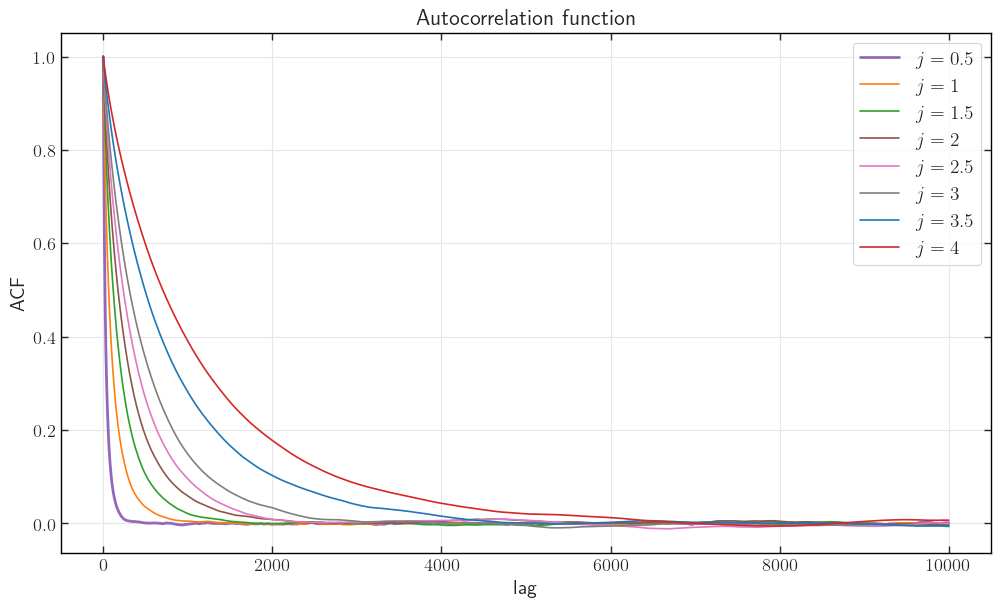

In [22]:
ax = df1.plot(
    x="lags",
    y="spin 0.5",
    # s=20,
    # xticks=corresponding_spin,
    kind="line",
    grid="false",
    color="tab:purple",
    label=r"$j = 0.5$",
    figsize=(12, 6.75),
)
df1.plot(
    x="lags",
    y="spin 1",
    ax=ax,
    kind="line",
    color="tab:orange",
    linewidth=1.2,
    label=r"$j = 1$",
)
df1.plot(
    x="lags",
    y="spin 1.5",
    ax=ax,
    kind="line",
    color="tab:green",
    linewidth=1.2,
    label=r"$j = 1.5$",
)
df1.plot(
    x="lags",
    y="spin 2",
    ax=ax,
    kind="line",
    color="tab:brown",
    linewidth=1.2,
    label=r"$j = 2$",
)
df1.plot(
    x="lags",
    y="spin 2.5",
    ax=ax,
    kind="line",
    color="tab:pink",
    linewidth=1.2,
    label=r"$j = 2.5$",
)
df1.plot(
    x="lags",
    y="spin 3",
    ax=ax,
    kind="line",
    color="tab:gray",
    linewidth=1.2,
    label=r"$j = 3$",
)
df1.plot(
    x="lags",
    y="spin 3.5",
    ax=ax,
    kind="line",
    color="tab:blue",
    linewidth=1.2,
    label=r"$j = 3.5$",
)
df1.plot(
    x="lags",
    y="spin 4",
    ax=ax,
    kind="line",
    color="tab:red",
    linewidth=1.2,
    label=r"$j = 4$",
)
plt.legend(fontsize=14)
# ax.set_ylim([-0.323, -0.343])
# plt.ylabel(r"$\langle \cos (\theta) \rangle$")
plt.ylabel("ACF")
plt.xlabel("lag")
plt.title("Autocorrelation function", fontsize=16)


# save the plot
printfile = "./plots/angles_autocorrelations"
plt.savefig(printfile + ".svg")
# plt.savefig(printfile + ".png", dpi=300)

plt.show()